In [424]:
import pandas as pd
import torch
import numpy as np

from sklearn.model_selection import train_test_split
from utils.covariate_data_processing import pbc2_proccess_covariate, padded_mask_processing

In [478]:
df = pd.read_csv(
    "/Users/davidlee/Documents/GitHub/Surtimesurvival/Data Project/Pycox Lib/PBC2 Convariate Data/pbc2_data_proccessed_auton_covariate.csv")

In [479]:
df.head()

,event,time,seq_id,seq_time_id,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_platelets,seq_temporal_prothrombin,...,seq_temporal_drug_1.0,seq_temporal_edema_1.0,seq_temporal_edema_2.0,seq_temporal_hepatomegaly_1.0,seq_temporal_hepatomegaly_2.0,seq_temporal_histologic_1.0,seq_temporal_histologic_2.0,seq_temporal_histologic_3.0,seq_temporal_spiders_1.0,seq_temporal_spiders_2.0
0,1.0,0.569489,0,0.569489,-1.485263,0.248058,-0.894575,0.195532,-0.529101,0.136768,...,0,1,0,1,0,0,0,1,1,0
1,1.0,0.569489,0,1.095170,0.195488,0.248058,-1.570646,0.285613,-0.456022,0.813132,...,0,1,0,1,0,0,0,1,1,0
2,0.0,14.152338,1,5.319790,-0.442126,1.292856,-1.431455,-0.605844,-1.395605,0.339677,...,0,1,0,1,0,0,1,0,1,0
3,0.0,14.152338,1,6.261636,-0.046806,1.292856,-1.172958,-0.512364,-1.259888,0.339677,...,0,1,0,1,0,0,1,0,1,0
4,0.0,14.152338,1,7.266455,0.293680,1.292856,-1.312149,-0.443529,-1.364286,0.339677,...,0,1,0,1,0,0,1,0,1,0


In [480]:
df_temp = df.loc[0:, ['seq_id', 'seq_time_id', 'event', 'time']]
df = df.drop(columns=['seq_id', 'seq_time_id'])

In [481]:
df.head()

,event,time,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,...,seq_temporal_drug_1.0,seq_temporal_edema_1.0,seq_temporal_edema_2.0,seq_temporal_hepatomegaly_1.0,seq_temporal_hepatomegaly_2.0,seq_temporal_histologic_1.0,seq_temporal_histologic_2.0,seq_temporal_histologic_3.0,seq_temporal_spiders_1.0,seq_temporal_spiders_2.0
0,1.0,0.569489,-1.485263,0.248058,-0.894575,0.195532,-0.529101,0.136768,3.281890,1.169016e-16,...,0,1,0,1,0,0,0,1,1,0
1,1.0,0.569489,0.195488,0.248058,-1.570646,0.285613,-0.456022,0.813132,2.015877,-4.694608e-01,...,0,1,0,1,0,0,0,1,1,0
2,0.0,14.152338,-0.442126,1.292856,-1.431455,-0.605844,-1.395605,0.339677,0.172710,-6.589138e-01,...,0,1,0,1,0,0,1,0,1,0
3,0.0,14.152338,-0.046806,1.292856,-1.172958,-0.512364,-1.259888,0.339677,-0.013468,-6.036567e-01,...,0,1,0,1,0,0,1,0,1,0
4,0.0,14.152338,0.293680,1.292856,-1.312149,-0.443529,-1.364286,0.339677,0.098239,1.169016e-16,...,0,1,0,1,0,0,1,0,1,0


In [482]:
df.rename(columns={'time': 'duration'}, inplace=True)

In [483]:
y, df, df_train, df_y_train = pbc2_proccess_covariate(df)

26.0
______
8
______
13
______
21
______
26
______
[2.73792575e-03 3.83309605e-02 1.86178951e-01 4.73661154e-01
 1.43056620e+01]
______
4


/Users/davidlee/Documents/GitHub/Surtimesurvival/SurvTRACE/survtrace/utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [484]:
df_train = pd.concat([df_train, df_temp['seq_id']], axis=1, join='inner')
df_y_train = pd.concat([df_y_train, df_temp['seq_id']], axis=1, join='inner')

In [485]:
masks, padded_patients = padded_mask_processing(df_train)

16 16


In [486]:
padded_patients.shape

torch.Size([312, 16, 21])

In [487]:
masks.shape

torch.Size([312, 16])

In [488]:
df_y_train = df_y_train.drop_duplicates(subset='seq_id', keep='last')
df_y_train = df_y_train.reset_index(drop=True)
df_y_train = df_y_train.drop(columns=['seq_id'])

In [489]:
df_y_train.head()

,duration,event,proportion
0,3,1.0,0.006928
1,3,0.0,0.988915
2,3,1.0,0.019002
3,2,1.0,0.314286
4,3,0.0,0.263658


In [490]:
df_temp = df_temp.drop_duplicates(subset='seq_id', keep='last')
df_temp = df_temp.reset_index(drop=True)
df_temp = df_temp.drop(columns=['seq_id'])

In [491]:
df_temp.head()

,seq_time_id,event,time
0,1.095170,1.0,0.569489
1,14.152338,0.0,14.152338
2,2.770781,1.0,0.736502
3,5.270507,1.0,0.276531
4,4.120578,0.0,4.120578


In [492]:
X_features_data_tensor = padded_patients
Y_labels_data_tensor = torch.tensor(df_y_train.values)

In [493]:
Y_labels = Y_labels_data_tensor[:, 1]
Y_labels = Y_labels.long()

In [494]:
Y_labels

tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [495]:
import torch
from torch.utils.data import TensorDataset

X_train, X_val, y_train, y_val, masks_train, masks_val, df_temp_train, df_temp_val = train_test_split(
    X_features_data_tensor, Y_labels, masks, df_temp,
    test_size=0.3)


X_val, X_test, y_val, y_test, masks_val, masks_test, df_temp_val, df_temp_test = train_test_split(X_val, y_val,
                                                                                                  masks_val,
                                                                                                  df_temp_val,
                                                                                                  test_size=0.7)
train_data = TensorDataset(X_train, y_train, masks_train)
val_data = TensorDataset(X_val, y_val, masks_val)
test_data = TensorDataset(X_test, y_test, masks_test)

In [496]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from model.survtimesurvival_model import TransformerClassifierFirstSolution, TransformerClassifier

# # Hyperparameters 1
# # input_dim = 26
# embed_dim = 16
# num_heads = 2
# ffn_hidden_dim = 64
# num_layers = 2
# batch_size = 8
# num_classes = 2

# Hyperparameters
# input_dim = 26
embed_dim = 32
num_heads = 2
ffn_hidden_dim = 64
num_layers = 2
batch_size = 4
num_classes = 2

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Set up training configurations
input_dim = X_features_data_tensor.size(2)
seq_length = X_features_data_tensor.size(1)

print("Input Dimension", input_dim)
print("Sequence Length", seq_length)

model = TransformerClassifierFirstSolution(input_dim, seq_length, embed_dim, num_heads, ffn_hidden_dim, num_layers, 2)

Input Dimension 21
Sequence Length 16


In [497]:
# HUNG: IMPORTANCE. IF YOU KEEP nn.CrossEntropyLoss(), this loss will return a number!!!!
# criterion = torch.nn.NLLLoss(reduction="none")
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [498]:
# Train the model
num_epochs = 40
train_loss_his = []
val_loss_his = []
val_accuracy_his = []

patience = 3
best_val_loss = None
epochs_since_best_val_loss = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target, label_mask) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data, label_mask)
        loss = criterion(output, target)
        # Assume loss has shape (B, S, D). Assume mask has shape (B, S)
        # Apply label mask to the loss.
        # In the label. Assume 1 is NOT PAD, and 0 is pad.
        loss = (loss * label_mask.unsqueeze(-1).float())

        # Average over the third dimension
        loss = loss.mean(-1)

        # Average over each sequence (dimension 1).
        # Since each sequence has different length. We need to do this
        loss = torch.sum(loss, dim=-1) / torch.sum(label_mask, dim=-1, keepdim=True)

        # Then average over the batch
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluate on validation set
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for batch_idx, (data, target, masks) in enumerate(val_loader):
            output = model(data, masks)
            loss = criterion(output, target)
            # val_running_loss += loss.item()
            val_running_loss += loss.sum().item()
            # val_running_loss += loss.mean().item()
            preds = output.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_targets.extend(target.cpu().numpy())

    # Calculate the accuracy of the model on the validation set
    val_accuracy = accuracy_score(val_targets, val_preds)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {running_loss / len(train_loader)}, "
          f"Validation Loss: {val_running_loss / len(val_loader)}, "
          f"Validation Accuracy: {val_accuracy}")

    train_loss_his.append(running_loss / len(train_loader))
    val_loss_his.append(val_running_loss / len(val_loader))
    val_accuracy_his.append(val_accuracy)
    if best_val_loss is None or abs(val_running_loss) < abs(best_val_loss):
        best_val_loss = val_running_loss
        epochs_since_best_val_loss = 0
    else:
        epochs_since_best_val_loss += 1

    if epochs_since_best_val_loss > patience:
        print(f"Early stopping triggered. No improvement in validation loss for {patience} consecutive epochs.")
        break

/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 1/40, Training Loss: 0.9972145156426864, Validation Loss: 2.1837154115949358, Validation Accuracy: 0.8571428571428571


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 2/40, Training Loss: 0.93010308471593, Validation Loss: 1.9133704049246651, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 3/40, Training Loss: 0.967622907595201, Validation Loss: 2.0609756878444125, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 4/40, Training Loss: 0.8532691917636178, Validation Loss: 1.8978992530277796, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 5/40, Training Loss: 0.8194473293694583, Validation Loss: 1.847433124269758, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 6/40, Training Loss: 0.8241260636936535, Validation Loss: 1.8009126356669836, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 7/40, Training Loss: 0.8355994527990168, Validation Loss: 2.027217217854091, Validation Accuracy: 0.7857142857142857


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 8/40, Training Loss: 0.7677018626169725, Validation Loss: 1.8151275941303797, Validation Accuracy: 0.8214285714285714


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 9/40, Training Loss: 0.8310455311428416, Validation Loss: 1.9949149915150233, Validation Accuracy: 0.7857142857142857


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 10/40, Training Loss: 0.8336658412759954, Validation Loss: 1.7008791991642542, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 11/40, Training Loss: 0.8096562640233473, Validation Loss: 1.731506041118077, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 12/40, Training Loss: 0.7332844772122123, Validation Loss: 1.679926804133824, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 13/40, Training Loss: 0.7739439660852606, Validation Loss: 1.6324997799737113, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 14/40, Training Loss: 0.7425479211590507, Validation Loss: 1.6910142047064645, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 15/40, Training Loss: 0.7328915585171093, Validation Loss: 2.5525608403342113, Validation Accuracy: 0.6428571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 16/40, Training Loss: 0.6869712618264285, Validation Loss: 1.7303889308656966, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 17/40, Training Loss: 0.6816967937079343, Validation Loss: 1.618260417665754, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 18/40, Training Loss: 0.7388393212448466, Validation Loss: 1.917988589831761, Validation Accuracy: 0.8571428571428571


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 19/40, Training Loss: 0.7103340306065299, Validation Loss: 1.669463838849749, Validation Accuracy: 0.8928571428571429


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


Epoch 20/40, Training Loss: 0.7375855174931613, Validation Loss: 1.8967156750815255, Validation Accuracy: 0.8214285714285714
Epoch 21/40, Training Loss: 0.7338091124187817, Validation Loss: 1.7636021716254098, Validation Accuracy: 0.8571428571428571
Early stopping triggered. No improvement in validation loss for 3 consecutive epochs.


/Users/davidlee/opt/anaconda3/envs/synthcity/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


In [499]:
torch.save(model.state_dict(), 'pre_trained_timevisit_seperatedtesting.pth')

In [500]:
from model.survtimesurvival_model import TransformerClassifier_2

In [501]:
model = TransformerClassifier_2(input_dim, seq_length, embed_dim, num_heads, ffn_hidden_dim, num_layers, num_classes)
pretrained_weights = torch.load('pre_trained_timevisit_seperatedtesting.pth')
#pretrained_weight/
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [502]:
masks, padded_patients = padded_mask_processing(df_train)

16 16


In [503]:
new_embedding_train = []
new_embedding_val = []
new_embedding_test = []

for i in range(len(masks_train)):
    a = masks_train[i].unsqueeze(0)
    output = model(X_train[i], a)
    new_embedding_train.append(output)

for i in range(len(masks_val)):
    a = masks_val[i].unsqueeze(0)
    output = model(X_val[i], a)
    new_embedding_val.append(output)

for i in range(len(masks_test)):
    a = masks_test[i].unsqueeze(0)
    output = model(X_test[i], a)
    new_embedding_test.append(output)

In [504]:
# Convert each tensor to a numpy array and stack them - training
numpy_arrays_train = [tensor.detach().numpy() for tensor in new_embedding_train]
numpy_array_train = np.stack(numpy_arrays_train, axis=-1)  # this stacks along a new third dimension

# Convert each tensor to a numpy array and stack them - validating
numpy_arrays_val = [tensor.detach().numpy() for tensor in new_embedding_val]
numpy_array_val = np.stack(numpy_arrays_val, axis=-1)  # this stacks along a new third dimension

# Convert each tensor to a numpy array and stack them - test
numpy_arrays_test = [tensor.detach().numpy() for tensor in new_embedding_test]
numpy_array_test = np.stack(numpy_arrays_test, axis=-1)  # this stacks along a new third dimension

In [505]:
new_df_train = pd.DataFrame(numpy_array_train[0])
new_df_train = new_df_train.transpose()

new_df_val = pd.DataFrame(numpy_array_val[0])
new_df_val = new_df_val.transpose()

new_df_test = pd.DataFrame(numpy_array_test[0])
new_df_test = new_df_test.transpose()

In [506]:
df_temp_train = df_temp_train.reset_index(drop=True)
df_temp_val = df_temp_val.reset_index(drop=True)
df_temp_test = df_temp_test.reset_index(drop=True)

In [507]:
df_temp_train.head()

,seq_time_id,event,time
0,2.335451,1.0,0.473661
1,8.687438,0.0,8.687438
2,2.658526,1.0,2.234147
3,8.881831,1.0,0.095827
4,4.627095,1.0,1.311466


In [508]:
new_df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.126096,1.646644,2.172218,-1.636963,1.532910,1.346032,-1.430197,-0.195876,-1.533542,0.947405,...,-1.087480,-1.730880,-2.118882,-1.793941,-1.690622,-1.845966,1.572547,-0.256498,-0.187671,0.747275
1,-1.209634,-1.543773,-1.981741,1.188085,-2.077871,-1.345008,1.293467,0.188824,1.178440,-0.227062,...,0.995066,1.418259,2.771489,1.714831,1.715206,0.722500,-1.818909,0.131576,0.596546,-0.118440
2,1.469509,1.940709,2.605440,-2.121652,2.022597,1.712738,-1.851819,-0.362513,-1.838555,1.276778,...,-1.473474,-2.267964,-2.570660,-2.261028,-2.055292,-2.418810,1.899886,-0.375268,-0.147550,0.921145
3,0.407677,0.353925,0.672073,-0.300273,0.471352,0.429659,-0.495072,-0.275170,-0.038910,-0.190123,...,-0.380610,-0.682533,-0.733835,-0.886241,-0.722078,-0.067345,0.446472,-0.159605,0.105730,0.063958
4,-0.692979,-0.826153,-1.060007,0.362258,-1.316869,-0.796186,0.868331,0.174400,0.518022,0.215048,...,0.664552,0.546628,1.720419,0.856709,1.081087,0.075821,-0.835077,0.011123,0.362890,0.182864


In [509]:
dataframe_for_survtrace_train = pd.concat([new_df_train, df_temp_train], axis=1)
dataframe_for_survtrace_val = pd.concat([new_df_val, df_temp_val], axis=1)
dataframe_for_survtrace_test = pd.concat([new_df_test, df_temp_test], axis=1)

In [510]:
# new_embedding = []
# for i in range(len(masks)):
#     a = masks[i].unsqueeze(0)
#     output = model(X_features_data_tensor[i], a)
#     new_embedding.append(output)

In [511]:
# # Convert each tensor to a numpy array and stack them
# numpy_arrays = [tensor.detach().numpy() for tensor in new_embedding]
# numpy_array = np.stack(numpy_arrays, axis=-1) # this stacks along a new third dimension

In [512]:
# new_df = pd.DataFrame(numpy_array[0])
# new_df = new_df.transpose()

In [513]:
# dataframe_for_survtrace = pd.concat([new_df, df_y_train], axis=1)

In [514]:
# dataframe_for_survtrace.head()

In [515]:
# df_temp.head()

In [516]:
dataframe_for_survtrace_train.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,seq_time_id,event,time
0,1.126096,1.646644,2.172218,-1.636963,1.532910,1.346032,-1.430197,-0.195876,-1.533542,0.947405,...,-1.793941,-1.690622,-1.845966,1.572547,-0.256498,-0.187671,0.747275,2.335451,1.0,0.473661
1,-1.209634,-1.543773,-1.981741,1.188085,-2.077871,-1.345008,1.293467,0.188824,1.178440,-0.227062,...,1.714831,1.715206,0.722500,-1.818909,0.131576,0.596546,-0.118440,8.687438,0.0,8.687438
2,1.469509,1.940709,2.605440,-2.121652,2.022597,1.712738,-1.851819,-0.362513,-1.838555,1.276778,...,-2.261028,-2.055292,-2.418810,1.899886,-0.375268,-0.147550,0.921145,2.658526,1.0,2.234147
3,0.407677,0.353925,0.672073,-0.300273,0.471352,0.429659,-0.495072,-0.275170,-0.038910,-0.190123,...,-0.886241,-0.722078,-0.067345,0.446472,-0.159605,0.105730,0.063958,8.881831,1.0,0.095827
4,-0.692979,-0.826153,-1.060007,0.362258,-1.316869,-0.796186,0.868331,0.174400,0.518022,0.215048,...,0.856709,1.081087,0.075821,-0.835077,0.011123,0.362890,0.182864,4.627095,1.0,1.311466


In [517]:
location_test = dataframe_for_survtrace_test.shape[0]
print(location_test)

66


In [518]:
dataframe_for_survtrace = pd.concat([dataframe_for_survtrace_test, dataframe_for_survtrace_val, dataframe_for_survtrace_train])
dataframe_for_survtrace.columns = dataframe_for_survtrace.columns.astype(str)
dataframe_for_survtrace = dataframe_for_survtrace.drop(columns=['seq_time_id'])
dataframe_for_survtrace.rename(columns={'time': 'duration'}, inplace=True)

In [519]:
dataframe_for_survtrace.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', 'event', 'duration'],
      dtype='object')

In [520]:
dataframe_for_survtrace = dataframe_for_survtrace.reset_index(drop=True)

In [521]:
# dataframe_for_survtrace = pd.concat([dataframe_for_survtrace, df_temp['seq_time_id']], axis=1)

In [522]:
# dataframe_for_survtrace.rename(columns={'proportion': 'proportion_1'}, inplace=True)
# dataframe_for_survtrace.columns = dataframe_for_survtrace.columns.astype(str)

In [523]:
# df_2 = dataframe_for_survtrace.drop(columns=['duration', 'proportion_1'])
# df_2.rename(columns={'seq_time_id': 'duration'}, inplace=True)

In [524]:
# df_2.info()

In [525]:
from utils.covariate_data_processing import pbc2_proccess_covariate_firstsolution

In [526]:
y, df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = pbc2_proccess_covariate_firstsolution(dataframe_for_survtrace, location_test)

0
______
21
______
0
______
21
______
0
______
[2.73792575e-03 1.00618771e-01 2.72423612e-01 7.07753806e-01
 1.43056620e+01]
______
4


/Users/davidlee/Documents/GitHub/Surtimesurvival/SurvTRACE/survtrace/utils.py:78: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [527]:
from SurvTRACE.survtrace.utils import set_random_seed
from SurvTRACE.survtrace.model import SurvTraceSingle
from SurvTRACE.survtrace.config import STConfig
from SurvTRACE.survtrace.train_utils import Trainer

set_random_seed(STConfig['seed'])

hparams = {
    'batch_size': 16,
    'weight_decay': 1e-4,
    'learning_rate': 1e-3,
    'epochs': 20,
}

In [528]:
# get model
model = SurvTraceSingle(STConfig)

# initialize a trainer
trainer = Trainer(model)
train_loss, val_loss = trainer.fit(train_set=(df_train, df_y_train), val_set=(df_val, df_y_val),
                                   batch_size=hparams['batch_size'],
                                   epochs=hparams['epochs'],
                                   learning_rate=hparams['learning_rate'],
                                   weight_decay=hparams['weight_decay'], )

GPU not found! will use cpu for training!
[Train-0]: 14.285359501838684
[Val-0]: 1.176551342010498
[Train-1]: 12.504767298698425
[Val-1]: 1.2878910303115845
EarlyStopping counter: 1 out of 5
[Train-2]: 11.05053973197937
[Val-2]: 1.2315373420715332
EarlyStopping counter: 2 out of 5
[Train-3]: 9.83653712272644
[Val-3]: 1.4384995698928833
EarlyStopping counter: 3 out of 5
[Train-4]: 8.661112785339355
[Val-4]: 1.2549031972885132
EarlyStopping counter: 4 out of 5
[Train-5]: 8.170238494873047
[Val-5]: 0.9292528629302979
[Train-6]: 7.0829132199287415
[Val-6]: 0.8872213363647461
[Train-7]: 7.209944307804108
[Val-7]: 0.8698325753211975
[Train-8]: 6.887489378452301
[Val-8]: 0.9541940689086914
EarlyStopping counter: 1 out of 5
[Train-9]: 6.968976318836212
[Val-9]: 0.8996212482452393
EarlyStopping counter: 2 out of 5
[Train-10]: 7.186865270137787
[Val-10]: 0.849778413772583
[Train-11]: 6.8765586614608765
[Val-11]: 0.8309640288352966
[Train-12]: 6.555235147476196
[Val-12]: 0.8112810850143433
[Train

In [529]:
# evaluate model
from SurvTRACE.survtrace.evaluate_utils import Evaluator

evaluator = Evaluator(df, df_train.index)
evaluator.eval(model, (df_test, df_y_test))
print("done")

******************************
start evaluation
******************************
For 0.25 quantile,
TD Concordance Index - IPCW: 0.9846153846153847
Brier Score: 0.030192033552973015
For 0.5 quantile,
TD Concordance Index - IPCW: 0.8214936247723132
Brier Score: 0.10959206462068709
For 0.75 quantile,
TD Concordance Index - IPCW: 0.8435462842242504
Brier Score: 0.15762614726877233
done


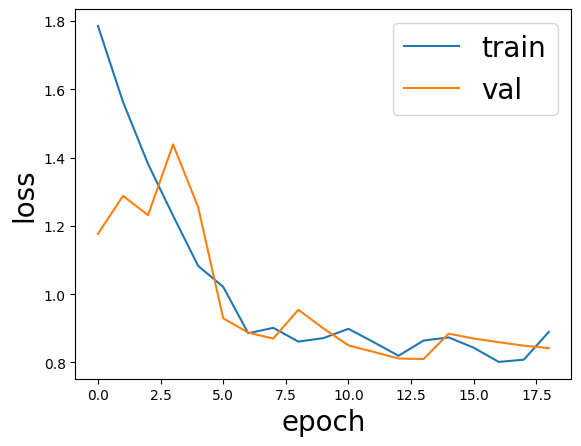

In [530]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()